# Creating cluster prototypes for the test set using TCN

In [33]:
import pickle
from electricity.model import TCN
import os
import argparse
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib import rc
from electricity.data import ElectricityDataSet
import numpy as np
import pandas as pd
import datetime

from torch.utils.data import DataLoader

from similarities.similarities import calculate_similarity_matrix
from representations.representations import calculate_representation
from sklearn.cluster import *

In [2]:
cluster_style = {
    "axes.spines.left": False,
    "axes.spines.right": False,
    "axes.spines.bottom": False,
    "axes.spines.top": False,
    "axes.grid": False,
    "xtick.bottom": False,
    "ytick.left": False,
}
ts_style = {
    "axes.spines.left": True,
    "axes.spines.right": False,
    "axes.spines.bottom": True,
    "axes.spines.top": False,
    "axes.grid": False,
    "xtick.bottom": True,
    "ytick.left": True,
}
rc("text", usetex=True)

In [3]:
MODEL_PATH = "Z:\TCN_clone\TCN\electricity\models\8e083e2c7751418587a58a960a7ac3fd.pt"

In [7]:
args = pickle.load(open(f"{MODEL_PATH}__args.pkl", "rb"))

model = TCN(
    num_layers=args.num_layers,
    in_channels=1,
    out_channels=1,
    residual_blocks_channel_size=[args.res_block_size]*args.num_layers,
    kernel_size=args.kernel_size,
    bias=args.bias,
    dropout=args.dropout,
    stride=1,
    leveledinit=args.leveledinit,
    embedding_dim=args.embedding_dim,
    embed=args.embed,
)
model.load_state_dict(torch.load(MODEL_PATH, map_location="cpu"))
model.eval()

TCN(
  (tcn): TemporalConvolutionalNetwork(
    (net): Sequential(
      (0): ResidualBlock(
        (dcc1): DilatedCausalConv(1, 32, kernel_size=(7,), stride=(1,))
        (drop1): Dropout(p=0.2, inplace=False)
        (dcc2): DilatedCausalConv(32, 32, kernel_size=(7,), stride=(1,))
        (drop2): Dropout(p=0.2, inplace=False)
        (res_conv): Conv1d(1, 32, kernel_size=(1,), stride=(1,))
      )
      (1): ResidualBlock(
        (dcc1): DilatedCausalConv(32, 32, kernel_size=(7,), stride=(1,), dilation=(2,))
        (drop1): Dropout(p=0.2, inplace=False)
        (dcc2): DilatedCausalConv(32, 32, kernel_size=(7,), stride=(1,), dilation=(2,))
        (drop2): Dropout(p=0.2, inplace=False)
      )
      (2): ResidualBlock(
        (dcc1): DilatedCausalConv(32, 32, kernel_size=(7,), stride=(1,), dilation=(4,))
        (drop1): Dropout(p=0.2, inplace=False)
        (dcc2): DilatedCausalConv(32, 32, kernel_size=(7,), stride=(1,), dilation=(4,))
        (drop2): Dropout(p=0.2, inplace=Fa

In [121]:
ds_train_unscaled = ElectricityDataSet(
    file_path="electricity/data/electricity.npy",
    data_scale=False,
    data_scaler=None,
    start_date="2012-01-01",
    end_date="2014-12-16",
    receptive_field=0,
)
ds_train_scaled = ElectricityDataSet(
    file_path="electricity/data/electricity.npy",
    data_scale=True,
    data_scaler=None,
    start_date="2012-01-01",
    end_date="2014-12-16",
    receptive_field=0,
)
ds_test_unscaled = ElectricityDataSet(
    file_path="electricity/data/electricity.npy",
    data_scale=False,
    data_scaler=ds_train_scaled.data_scaler,
    receptive_field=385,
    start_date="2014-12-16",
    end_date="2014-12-23",
)
ds_test_scaled = ElectricityDataSet(
    file_path="electricity/data/electricity.npy",
    data_scale=True,
    data_scaler=ds_train_scaled.data_scaler,
    receptive_field=385,
    start_date="2014-12-16",
    end_date="2014-12-23",
)

Dimension of X :  torch.Size([370, 1, 25944])
Dimension of Y :  torch.Size([370, 1, 25944])
Dimension of X :  torch.Size([370, 1, 25944])
Dimension of Y :  torch.Size([370, 1, 25944])
Dimension of X :  torch.Size([370, 1, 192])
Dimension of Y :  torch.Size([370, 1, 192])
Dimension of X :  torch.Size([370, 1, 192])
Dimension of Y :  torch.Size([370, 1, 192])


In [122]:
X_train = ds_train_unscaled.X.squeeze(1).detach().cpu().numpy()
X_train_scaled = ds_train_scaled.X.squeeze(1).detach().cpu().numpy()
X_test = ds_test.X.squeeze(1).detach().cpu().numpy()
X_test_scaled = ds_test_scaled.X.squeeze(1).detach().cpu().numpy()

In [123]:
rep = calculate_representation(X_train, "pca", num_components=10)

Num components  10
Num components  10
Explained variance ratio: 0.9995136857032776


In [124]:
#sim = calculate_similarity_matrix(rep, dist_or_sim="feat")

In [125]:
kmeans = KMeans(n_clusters=10)
clusters = kmeans.fit_predict(rep)

In [126]:
cluster_dist = {
        c: len(clusters[np.where(clusters == c)]) for c in range(len(set(clusters)))
    }
for k, v in cluster_dist.items():
    print(f"{k:2} : {v}")
cluster_dict = {i: clusters[i] for i in range(len(clusters))}

0 : 14
 1 : 1
 2 : 262
 3 : 1
 4 : 1
 5 : 1
 6 : 2
 7 : 28
 8 : 4
 9 : 56


In [127]:
def create_prototypes(clusters, Y, num_examples: int = 3):
    prototypes = {}
    examples = {}
    sizes = {}
    for c in set(clusters):
        # get all ts from Y that are in cluster c
        ids = np.where(clusters == c)[0]

        # take mean
        ts = Y[ids]
        prot = np.mean(ts, axis=0)
        # store in dict
        prototypes[c] = prot
        sizes[c] = len(ids)

    return prototypes, examples, sizes

In [128]:
prototypes, examples, sizes = create_prototypes(clusters, X_train_scaled, num_examples=3)

([<matplotlib.lines.Line2D at 0x25e96f3fe88>],
 [<matplotlib.lines.Line2D at 0x25e9532b488>])

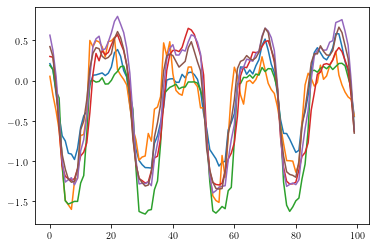

In [129]:
plt.plot(prototypes[0][-100:]), plt.plot(prototypes[4][-100:]), plt.plot(prototypes[6][-100:]), plt.plot(prototypes[8][-100:]), plt.plot(prototypes[7][-100:]), plt.plot(prototypes[9][-100:])

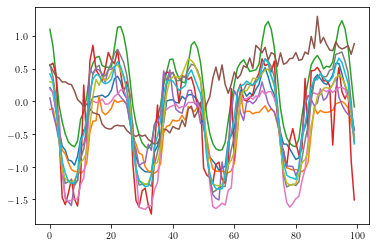

In [130]:
for i in range(10):
    plt.plot(prototypes[i][-100:])

In [133]:
p = torch.from_numpy(prototypes[0]).view(1,1,-1)

In [139]:
test_prototypes, _, _ = create_prototypes(clusters, X_test_scaled, num_examples=3)
p_test = torch.from_numpy(test_prototypes[0]).view(1,1,-1)

In [144]:
full_prototype = torch.cat((p, p_test[:,:,-24*7:]),2)

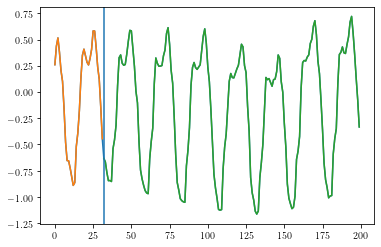

In [159]:
plt.plot(full_prototype.squeeze(1).detach().cpu().numpy()[0][-200:])
plt.plot(p.squeeze(1).detach().cpu().numpy()[0][-32:])
plt.plot([i for i in range(32,200)], p_test.squeeze(1).detach().numpy()[0][-24*7:])
plt.axvline([200-24*7])

In [164]:
with torch.no_grad():
    pred_prototype, _ = model.rolling_prediction(full_prototype, num_windows=7, tau=24, emb_id=0)

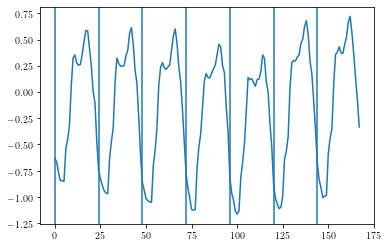

In [168]:
plt.plot(full_prototype.squeeze(1).detach().cpu().numpy())
plt.plot(pred_prototype.squeeze(1).detach().cpu().numpy()[-24*7:])
for i in range(7):
    plt.axvline(i*24)

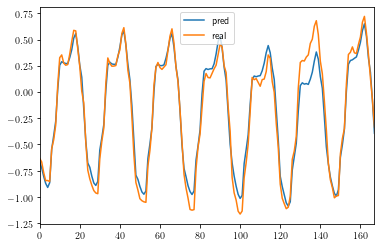

In [182]:
d = {}
d["pred"] = pred_prototype.squeeze()
d["real"] = full_prototype[:,:,-24*7:].squeeze()
df = pd.DataFrame(d)
df.plot()
#plt.plot(pred_prototype.squeeze())
#plt.plot(full_prototype[:,:,-24*7:].squeeze())
#plt.legend(["pred", "true"])

In [183]:
pred_prototype.shape

torch.Size([1, 168])

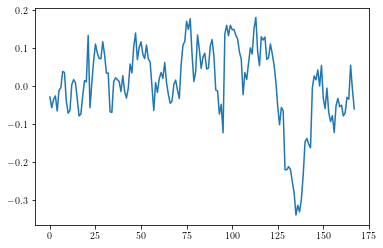

In [177]:
plt.plot(pred_prototype.squeeze() - full_prototype[:,:,-24*7:].squeeze())